### Libs

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import os
import torch
import math
# main libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
from torch.nn import functional as F
from torch import nn
from torch import optim
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import Dataset
import math
import torchvision.transforms.functional as TF
import cv2
from keras.utils import image_dataset_from_directory
from torchvision import datasets, transforms
from torch.utils.data import random_split
from torch.nn.parameter import Parameter

from torch.nn import init
from torchvision.utils import make_grid
from collections import OrderedDict

In [ ]:
def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)

In [ ]:
class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

### Dataloader

In [ ]:
class Anomaly_Dataset(Dataset):
    def __init__(self,
                 root
                 ):
        super(Anomaly_Dataset, self).__init__()

        self.data = Anomaly_Dataset.load_dataset(root)
        self.image, self.label = Anomaly_Dataset.get_numpy(self.data)

    def __getitem__(self, item):
        x, y =  self.image[item], self.label[item]

        # RGB -> GRAY : (H, W)
        x = x[:,:,0]

        # (1, H, W)
        x = Anomaly_Dataset.normalization(x)
        #x = np.expand_dims(x, axis=0)

        return x, y


    def __len__(self):
        return len(self.data)


    @staticmethod
    def load_dataset(path):
        img_rows = 128
        img_cols = 128
        return image_dataset_from_directory(directory = path,
                                               label_mode = 'int',
                                               color_mode = 'rgb',
                                               shuffle = False,
                                               batch_size = None,
                                               image_size = (img_rows, img_cols),
                                               crop_to_aspect_ratio = True)

    @staticmethod
    def get_numpy(PrefetchDataset):
        """
        return:
            (N, H, W, C) , (N,)
        """
        images = []
        labels = []
        for (image, label) in PrefetchDataset:
            images.append(image)
            labels.append(label)
        return np.array(images), np.array(labels)

    @staticmethod
    def rgb_2_gray(x):
        """
        (H, W, C) --> (H, W)
        """
        return cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)

    @staticmethod
    def normalization(x):
        """
        Args:
            x : np.array : (H, W)

        Return:
            np.array : (H, W)
        """
        x = x - x.min(keepdims=True)
        x = x / x.max(keepdims=True)
        x = x - 0.5
        return  x / 0.5

### Noise

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
"""
def get_noise(num_z, z_dim, device='cpu'):
    # mean, std = 0, 1
    #return torch.empty(num_z, z_dim, 1, 1).normal_(mean, std).to(device)
    return torch.randn(num_z, z_dim, 1, 1, device=device)
"""

### Net

In [ ]:
class Encoder(nn.Module):

    def __init__(self, in_channels, init_features):
        super(Encoder, self).__init__()

        features = init_features
        self.encoder1 = Encoder._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = Encoder._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = Encoder._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = Encoder._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bottleneck = Encoder._block(features * 8, features * 16, name="bottleneck")


    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))
        bottleneck = self.bottleneck(self.pool4(enc4))

        return bottleneck, enc4, enc3, enc2, enc1


    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [ ]:
class Decoder(nn.Module):

    def __init__(self, init_features, out_channels):
        super(Decoder, self).__init__()

        features = init_features

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = Decoder._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = Decoder._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = Decoder._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = Decoder._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, bottleneck, enc4, enc3, enc2, enc1):
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.tanh(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [ ]:
class Generator(nn.Module):

    def __init__(self, in_channels, out_channels, init_features):
        super(Generator, self).__init__()

        features = init_features
        self.encoder = Encoder(in_channels, features)
        self.decoder = Decoder(features, out_channels)

    def forward(self, x):
        self.bottleneck, self.enc4, self.enc3, self.enc2, self.enc1 = self.encoder(x)
        x_hat = self.decoder(self.bottleneck, self.enc4, self.enc3, self.enc2, self.enc1)
        return x_hat

In [ ]:
from collections import OrderedDict

import torch
import torch.nn as nn


class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        self.upconv4 = nn.ConvTranspose2d(
            features * 16, features * 8, kernel_size=2, stride=2
        )
        self.decoder4 = UNet._block((features * 8) * 2, features * 8, name="dec4")
        self.upconv3 = nn.ConvTranspose2d(
            features * 8, features * 4, kernel_size=2, stride=2
        )
        self.decoder3 = UNet._block((features * 4) * 2, features * 4, name="dec3")
        self.upconv2 = nn.ConvTranspose2d(
            features * 4, features * 2, kernel_size=2, stride=2
        )
        self.decoder2 = UNet._block((features * 2) * 2, features * 2, name="dec2")
        self.upconv1 = nn.ConvTranspose2d(
            features * 2, features, kernel_size=2, stride=2
        )
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.conv = nn.Conv2d(
            in_channels=features, out_channels=out_channels, kernel_size=1
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return torch.sigmoid(self.conv(dec1))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (
                        name + "conv1",
                        nn.Conv2d(
                            in_channels=in_channels,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (
                        name + "conv2",
                        nn.Conv2d(
                            in_channels=features,
                            out_channels=features,
                            kernel_size=3,
                            padding=1,
                            bias=False,
                        ),
                    ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [ ]:
# TEST
N, C, H, W = 1, 1, 128, 128
x = torch.ones(N, C, H, W)
unet = UNet(1, 1, 8)
print(unet(x).shape)
count_parameters(unet)

In [ ]:
# TEST
N, C, H, W = 1, 1, 128, 128
x = torch.ones(N, C, H, W)
gen = Generator(1, 1, 8)
print(gen(x).shape)
count_parameters(gen)

In [ ]:
# Change activation to RELU
class Critic(nn.Module):
    def __init__(self , c_dim , df_dim):
        super(Critic, self).__init__()

        # torch.nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride=1, padding=0,
        #                          output_padding=0,groups=1, bias=True, dilation=1, padding_mode='zeros')

        self.critic = nn.Sequential(
            Critic._block(c_dim, df_dim),
            Critic._block(df_dim, df_dim*2),
            Critic._block(df_dim*2, df_dim*4),
            Critic._block(df_dim*4, 1, padding=0, final_layer=True),
        )

    def forward(self,inp):
        return self.critic(
            inp
        ).flatten(1) # (N , 1 , 1, 1 )

    @staticmethod
    def _block(in_channels, out_channels, kernel_size=4, stride=3, padding=1, final_layer=False):
        if final_layer:
            return nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        else:
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.LeakyReLU(negative_slope=0.2)
            )

In [ ]:
# TEST
N, C, H, W = 1, 1, 128, 128
x = torch.ones(N, C, H, W)
crit = Critic(C, 64)
print(crit(x).shape)
count_parameters(crit)

In [ ]:
"""
class Critic(nn.Module):
    def __init__(self, c_dim , df_dim=32):
        super(Critic, self).__init__()

        self.fea1 = nn.Sequential(
            SpectralNorm(nn.Conv2d(c_dim, df_dim, kernel_size=5, stride=2, padding=0)),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            SpectralNorm(nn.Conv2d(df_dim, df_dim*2, kernel_size=5, stride=2, padding=0)),
            nn.BatchNorm2d(df_dim*2, 0.5), nn.LeakyReLU(negative_slope=0.2, inplace=True),
            SpectralNorm(nn.Conv2d(df_dim*2, df_dim*4, kernel_size=3, stride=2, padding=0)),
            nn.BatchNorm2d(df_dim*4, 0.5), nn.LeakyReLU(negative_slope=0.2, inplace=True),
            SpectralNorm(nn.Conv2d(df_dim*4, df_dim*8, kernel_size=3, stride=2, padding=0)),
            nn.BatchNorm2d(df_dim*8, 0.5), nn.LeakyReLU(negative_slope=0.2, inplace=True),
            nn.AvgPool2d(kernel_size=6, stride=6))

        self.concat = nn.Sequential(nn.Dropout(0.2), nn.Linear(256, 128),
                                    nn.Dropout(0.2), nn.Linear(128, 1)
                                )

    def forward(self, img):
        fea1_out = self.fea1(img).flatten(start_dim=1)

        self.concat = nn.Sequential(nn.Dropout(0.2), nn.Linear(fea1_out.shape[1], int(fea1_out.shape[1]/2)),
                                    nn.Dropout(0.2), nn.Linear(int(fea1_out.shape[1]/2), 1)
                                ).to(self.fea1[0].module.bias.device)
        validity = self.concat(fea1_out)

        return validity
"""

In [ ]:
# TEST
N, C, H, W = 1, 1, 128, 128
x = torch.ones(N, C, H, W)
crit = Critic(C, 8)
print(crit(x).shape)
count_parameters(crit)

### Loss

In [ ]:
def get_epsilon(N_epsilon, device='cpu'):
    """
    Parameters:
        N_epsilon : Number of epsilons
    Output:
        e.g. shape : (128, 1, 1, 1)
    """
    return torch.rand(N_epsilon, 1, 1, 1, device=device, requires_grad=True)

In [ ]:
def get_gradient(crit, data):
    """
    Return the gradient of the critic's scores with respect to mixes of real and fake images.
    Parameters:
        dis: the critic model
        data: a batch of data
    Returns:
        gradient: the gradient of the discriminator's scores, with respect to data
    """

    # True require_grad of Data
    data.requires_grad_()
    # Calculate the discriminator's scores on the data
    score = crit(data)

    # Take the gradient of the scores with respect to the data
    gradient = torch.autograd.grad(
        inputs=data,
        outputs=score,
        # These other parameters have to do with the pytorch autograd engine works
        grad_outputs=torch.ones_like(score),
        create_graph=True,
        retain_graph=True,
    )[0]
    return gradient

In [ ]:
def gradient_penalty(gradient):
    '''
    Return the gradient penalty, given a gradient.
    Given a batch of data gradients, you calculate the magnitude of each data's gradient
    and penalize the mean quadratic distance of each magnitude to 1.

    Parameters:
        gradient: the gradient of the discriminator's scores, with respect to the data
        e.g shape  : (128, 1, 28, 28)

    Returns:
        penalty: the gradient penalty
        e.g shaoe : (scaler)
    '''

    # Flatten the gradients so that each row captures one image
    # e.g shape  : (128, 1, 28, 28) ==> (128, 784)
    gradient = gradient.view(len(gradient), -1)

    # Calculate the magnitude of every row
    # e.g shape : (128, 784) ==> (128, 1)
    gradient_norm = gradient.norm(2, dim=1)

    # Penalize the mean squared distance of the gradient norms from 1
    # e.g shape : (128, 1) ==> (scaler)
    penalty = ( ( gradient_norm - 1.0 )**2 ).mean(dim=0)
    return penalty

In [ ]:
def get_crit_loss(
    image,
    gen, crit,
    c_lambda,
    device):
    '''
    Parameters:
        All as same as DCGAN Losses
    Returns:
        dis_loss: a scalar for the dis's loss
    '''
    #x_no_tumor_fake = gen(x_tumor #+ get_noise(x_tumor, device=device)).detach()

    image_hat = gen(
        image
    ).detach()

    # Mixed "real" with "fake"
    #epsilon = get_epsilon(N_epsilon = x_no_tumor.shape[0], device=device)
    epsilon = get_epsilon(N_epsilon = image.shape[0], device=device)

    #mixed_images = x_no_tumor * epsilon + x_no_tumor_fake * (1 - epsilon)
    mixed_images = image * epsilon + image_hat * (1 - epsilon)

    # Calculate Gradient Penalty (use prior funcs)
    gp = gradient_penalty(get_gradient(crit, mixed_images))
    # Calculate "Line 7" of "Algorithm 1" in main paper
    #return ( dis(x_no_tumor_fake) - dis(x_no_tumor) + c_lambda * gp ).mean(dim=0)
    return ( crit(image_hat) - crit(image) + c_lambda * gp ).mean(dim=0)

In [ ]:
def get_gen_loss(
      image,
      gen, crit):
    '''
    Return the loss of a generator.
    Parameters:

    Returns:
       a scalar loss value for the current batch of the generator
    '''
    image_hat = gen(
        image
    )
    # Calculate "Line 12" of "Algorithm 1" in main paper
    return ( -crit(image_hat) ).mean(dim=0)

### Helper

In [ ]:
def ploter(image, image_hat):
    """
    (H, W)
    """
    plt.figure()
    plt.subplot(1,2,1)
    #plt.imshow(image_hat, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image_hat)
    plt.tight_layout()
    plt.title("Reconstruct")

    plt.subplot(1,2,2)
    #plt.imshow(image, cmap='gray', vmin=-1, vmax=1)
    plt.imshow(image)
    plt.tight_layout()
    plt.title("Original")

    plt.show()

In [ ]:
def weights_init(submodules):
    if isinstance(submodules, nn.Conv2d) or isinstance(submodules, nn.ConvTranspose2d):
        torch.nn.init.normal_(submodules.weight, 0.0, 0.02)
        #torch.nn.init.normal_(submodules.bias, 0.0, 0.02)
    if isinstance(submodules, nn.BatchNorm2d):
        torch.nn.init.normal_(submodules.weight, 0.0, 0.02)
        torch.nn.init.constant_(submodules.bias, 0)

In [ ]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 128, 128)):
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze(), cmap='gray', vmin=-1, vmax=1)
    plt.show()

### Hyperparamters

In [ ]:
c_dim , gf_dim = 1, 8
df_dim = 64

device = 'cuda'

# num_train = 80
batch_size =40
# batch_size = 10, 20, 40, 80


lr_gen, lr_crit = 0.0002, 0.0002
beta_1 = 0.5
beta_2 = 0.999

# epochs
epochs= 5000
disp_freq=1
display_step=1

crit_repeats=5
c_lambda = 10

step_bins = 1

In [ ]:
gen = Generator(c_dim, c_dim, gf_dim).to(device)
crit = Critic(c_dim, df_dim).to(device)

# Initialize
gen = gen.apply(weights_init)
crit = crit.apply(weights_init)


# Loss function
#criterion=nn.BCEWithLogitsLoss()

# Optimizers
optim_crit = torch.optim.Adam(crit.parameters(), lr=lr_crit, betas=(beta_1, beta_2))
optim_gen = torch.optim.Adam(gen.parameters(), lr=lr_gen, betas=(beta_1, beta_2))

### Dataset

In [ ]:
#root = "/content/drive/MyDrive/MRI Arman/kaggle1/no"
root = "./../dataset/kaggle1/no"
dataset = Anomaly_Dataset(root)

In [ ]:
#sampler
num_data = dataset.__len__()
num_valid = 11
num_train = num_data - num_valid #80

indices = list(range(num_data))
train_idx, valid_idx = indices[num_valid:], indices[:num_valid]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [ ]:
train_loader=DataLoader(dataset, batch_size= batch_size, sampler=train_sampler)
valid_loader=DataLoader(dataset, batch_size= num_valid, sampler=valid_sampler)

In [ ]:
for i, (x, y) in enumerate(train_loader, 1):
    x=x
    y=y

In [ ]:
plt.figure()
plt.imshow(x[0], cmap='gray', vmin=-1, vmax=1)

In [ ]:
import gc

gc.collect()

torch.cuda.empty_cache()

### Training

In [ ]:
cur_step = 0
generator_losses = []
critic_losses = []
mse_loss_min = np.Inf
mse_losses = []

In [ ]:
for epoch in range(1,epochs+1):
    print(60 * "#")
    print(6 * "#" + " Epoch " + str(epoch) + " " + 45 * "#")
    print(60 * "#")

    # Set mode on "train mode"
    gen.train()
    crit.train()

    for image_train,_ in train_loader:
        cur_batch_size = len(image_train)
        split = int(batch_size/2)

        image_gen = image_train[:split].unsqueeze(1).to(device)
        image_crit = image_train[split:].unsqueeze(1).to(device)


        # Discriminator Learning
        mean_iteration_critic_loss = 0
        for _ in range(crit_repeats):
          optim_crit.zero_grad()
          crit_loss  = get_crit_loss(image_crit, gen, crit, c_lambda, device=device)
          crit_loss .backward(retain_graph=True)
          optim_crit.step()
          mean_iteration_critic_loss += crit_loss.item() / crit_repeats
        critic_losses += [mean_iteration_critic_loss]

        # Generator Learning
        optim_gen.zero_grad()
        gen_loss  = get_gen_loss(image_gen, gen, crit)
        gen_loss .backward()
        optim_gen.step()
        generator_losses += [gen_loss.item()]

    for image_valid,_ in valid_loader:
        image_valid = image_valid.unsqueeze(1).to(device)
        image_hat = gen(image_valid)
        differ = nn.MSELoss()
        mse_loss = differ(image_hat, image_valid)
        mse_losses += [mse_loss.item()]

    if mse_loss<mse_loss_min:
        root_save = f"./../best_models/epoch_{epoch}_loss_{mse_loss.item()}.pt"
        torch.save({'epoch': epoch, 'Generator': gen.state_dict(), 'Critic': crit.state_dict()},
                  root_save)
        mse_loss_min = mse_loss

    ### Visualization code ###
    if cur_step % display_step == 0 and cur_step > 0:
        gen_mean = sum(generator_losses[-display_step:]) / display_step
        crit_mean = sum(critic_losses[-display_step:]) / display_step
        mse_mean = sum(mse_losses[-display_step:]) / display_step

        print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, critic loss: {crit_mean}")
        print(f"Epoch {epoch}, step {cur_step}: MSE loss: {mse_mean}")


        i=math.floor(np.random.uniform(0, image_valid.shape[0]))

        plt.figure()
        ploter(image_valid[i,0].detach().cpu(), image_hat[i,0].detach().cpu())
        plt.show()


        plt.figure()
        num_examples = (len(mse_losses) // step_bins) * step_bins
        plt.plot(
            range(num_examples // step_bins),
            torch.Tensor(mse_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="MSE Loss"
        )
        plt.show()


        plt.figure()
        num_examples = (len(generator_losses) // step_bins) * step_bins
        plt.plot(
            range(num_examples // step_bins),
            torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Generator Loss"
        )
        plt.plot(
            range(num_examples // step_bins),
            torch.Tensor(critic_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Critic Loss"
        )
        plt.legend()
        plt.show()
    cur_step += 1

    """
    if epoch % 250 == 0:
      root_save = f"/content/drive/MyDrive/MRI Arman/epoch_{epoch}.pt"
      torch.save({'epoch': epoch, 'Generator': gen.state_dict(), 'Critic': crit.state_dict()},
                  root_save)
    """

### TEEEEST

In [219]:
device = 'cuda'

lr_decoder = 0.002
beta_1 = 0.5
beta_2 = 0.999

# epochs
epochs= 100
disp_freq=10
display_step=10

crit_repeats=5
c_lambda = 10

step_bins = 1

In [220]:
# Abnormal Tumar
root = "./../dataset/kaggle1/tamiz"
dataset = Anomaly_Dataset(root)
test_loader = DataLoader(dataset, batch_size=1)

Found 1 files belonging to 1 classes.


<Figure size 432x288 with 0 Axes>

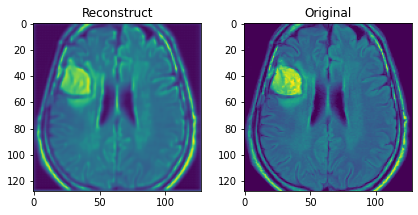

In [221]:
for image_test,_ in test_loader:
    image_test = image_test.unsqueeze(1).to(device)
    image_hat = gen(image_test)
    differ = nn.MSELoss()
    mse_loss = differ(image_hat, image_test)
    mse_losses += [mse_loss.item()]
i=0
plt.figure()
ploter(image_test[i,0].detach().cpu(), image_hat[i,0].detach().cpu())
plt.show()

In [222]:
# Best Generator and Criti
gen = Generator(c_dim, c_dim, gf_dim).to(device)
crit = Critic(c_dim, df_dim).to(device)

best_model = torch.load("./../epoch_174_loss_0.25_best_model.pt")

gen.load_state_dict(best_model['Generator'])
crit.load_state_dict(best_model['Critic'])

<All keys matched successfully>

In [223]:
bottleneck, enc4, enc3, enc2, enc1 = gen.encoder(image_test)
x_hat = gen.decoder(bottleneck, enc4, enc3, enc2, enc1)
bottleneck = Parameter(bottleneck)
enc4 = Parameter(enc4)
enc3 = Parameter(enc3)
enc2 = Parameter(enc2)
enc1 = Parameter(enc1)

In [224]:
def get_decoder_loss(decoder, crit):
    '''
    Return the loss of a generator.
    Parameters:

    Returns:
       a scalar loss value for the current batch of the generator
    '''
    image_hat = decoder()
    # Calculate "Line 12" of "Algorithm 1" in main paper
    return ( -crit(image_hat) ).mean(dim=0)

In [225]:
# Optimizers
optim_decoder = torch.optim.Adam([bottleneck, enc4, enc3], lr=lr_decoder, betas=(beta_1, beta_2))

In [226]:
import gc

gc.collect()

torch.cuda.empty_cache()

In [227]:
cur_step = 0
decoder_losses = []

# 1

############################################################
###### Epoch 1 #############################################
############################################################
############################################################
###### Epoch 2 #############################################
############################################################
############################################################
###### Epoch 3 #############################################
############################################################
############################################################
###### Epoch 4 #############################################
############################################################
############################################################
###### Epoch 5 #############################################
############################################################
############################################################
###### Epoch 6 #########

<Figure size 432x288 with 0 Axes>

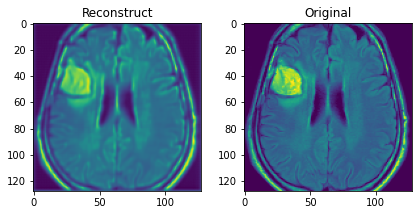

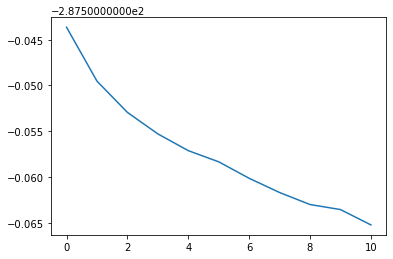

############################################################
###### Epoch 12 #############################################
############################################################
############################################################
###### Epoch 13 #############################################
############################################################
############################################################
###### Epoch 14 #############################################
############################################################
############################################################
###### Epoch 15 #############################################
############################################################
############################################################
###### Epoch 16 #############################################
############################################################
############################################################
###### Epoch 17 ###

<Figure size 432x288 with 0 Axes>

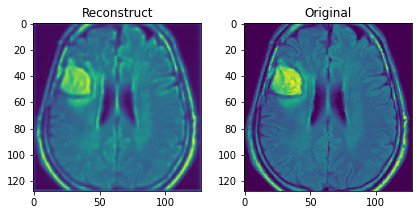

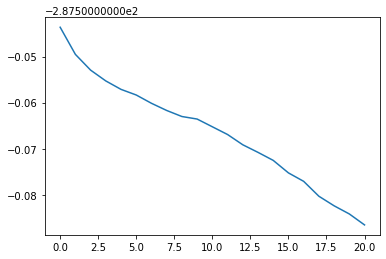

############################################################
###### Epoch 22 #############################################
############################################################
############################################################
###### Epoch 23 #############################################
############################################################
############################################################
###### Epoch 24 #############################################
############################################################
############################################################
###### Epoch 25 #############################################
############################################################
############################################################
###### Epoch 26 #############################################
############################################################
############################################################
###### Epoch 27 ###

<Figure size 432x288 with 0 Axes>

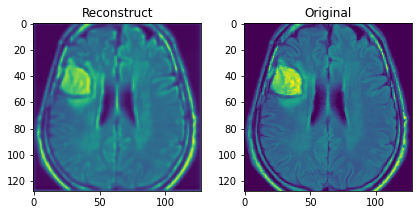

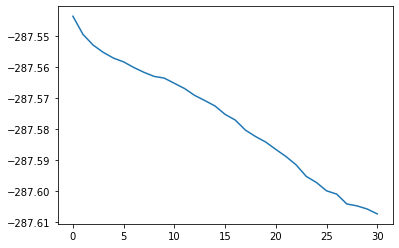

############################################################
###### Epoch 32 #############################################
############################################################
############################################################
###### Epoch 33 #############################################
############################################################
############################################################
###### Epoch 34 #############################################
############################################################
############################################################
###### Epoch 35 #############################################
############################################################
############################################################
###### Epoch 36 #############################################
############################################################
############################################################
###### Epoch 37 ###

<Figure size 432x288 with 0 Axes>

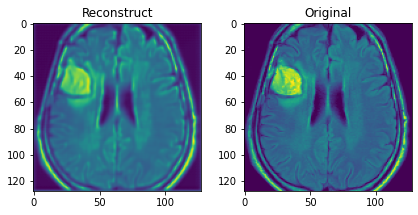

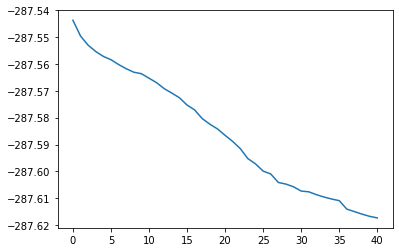

############################################################
###### Epoch 42 #############################################
############################################################
############################################################
###### Epoch 43 #############################################
############################################################
############################################################
###### Epoch 44 #############################################
############################################################
############################################################
###### Epoch 45 #############################################
############################################################
############################################################
###### Epoch 46 #############################################
############################################################
############################################################
###### Epoch 47 ###

<Figure size 432x288 with 0 Axes>

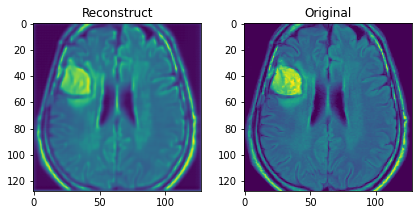

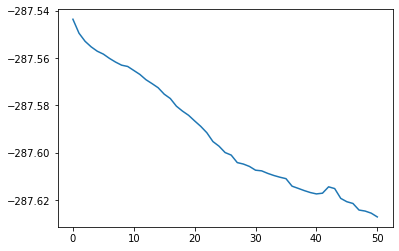

############################################################
###### Epoch 52 #############################################
############################################################
############################################################
###### Epoch 53 #############################################
############################################################
############################################################
###### Epoch 54 #############################################
############################################################
############################################################
###### Epoch 55 #############################################
############################################################
############################################################
###### Epoch 56 #############################################
############################################################
############################################################
###### Epoch 57 ###

<Figure size 432x288 with 0 Axes>

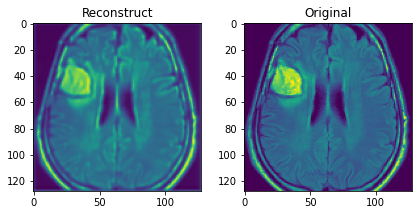

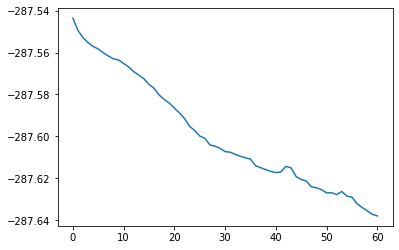

############################################################
###### Epoch 62 #############################################
############################################################
############################################################
###### Epoch 63 #############################################
############################################################
############################################################
###### Epoch 64 #############################################
############################################################
############################################################
###### Epoch 65 #############################################
############################################################
############################################################
###### Epoch 66 #############################################
############################################################
############################################################
###### Epoch 67 ###

<Figure size 432x288 with 0 Axes>

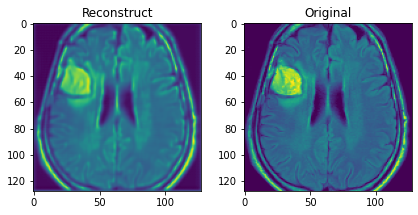

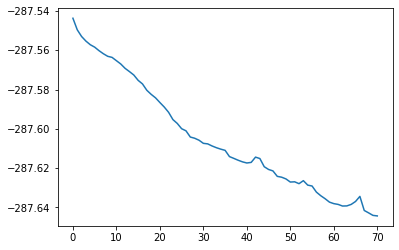

############################################################
###### Epoch 72 #############################################
############################################################
############################################################
###### Epoch 73 #############################################
############################################################
############################################################
###### Epoch 74 #############################################
############################################################
############################################################
###### Epoch 75 #############################################
############################################################
############################################################
###### Epoch 76 #############################################
############################################################
############################################################
###### Epoch 77 ###

<Figure size 432x288 with 0 Axes>

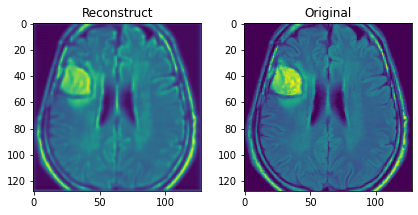

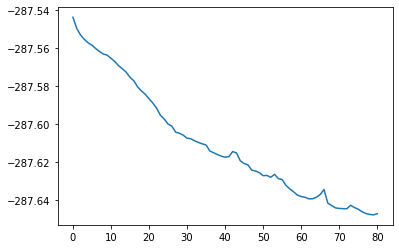

############################################################
###### Epoch 82 #############################################
############################################################
############################################################
###### Epoch 83 #############################################
############################################################
############################################################
###### Epoch 84 #############################################
############################################################
############################################################
###### Epoch 85 #############################################
############################################################
############################################################
###### Epoch 86 #############################################
############################################################
############################################################
###### Epoch 87 ###

<Figure size 432x288 with 0 Axes>

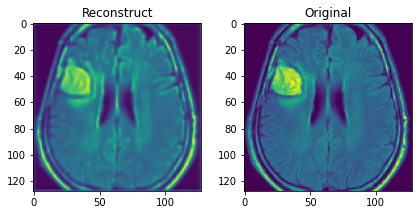

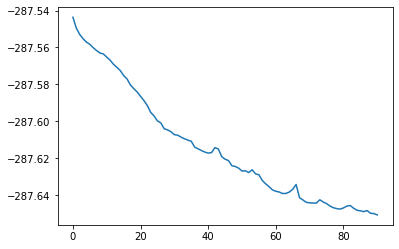

############################################################
###### Epoch 92 #############################################
############################################################
############################################################
###### Epoch 93 #############################################
############################################################
############################################################
###### Epoch 94 #############################################
############################################################
############################################################
###### Epoch 95 #############################################
############################################################
############################################################
###### Epoch 96 #############################################
############################################################
############################################################
###### Epoch 97 ###

In [231]:
for epoch in range(1,epochs+1):
    print(60 * "#")
    print(6 * "#" + " Epoch " + str(epoch) + " " + 45 * "#")
    print(60 * "#")

    # Set mode on "train mode"
    gen.train()
    crit.eval()
    for image_test,_ in test_loader:
        cur_batch_size = len(image_test)

        image_test = image_test.unsqueeze(1).to(device)

        # Decoder Star Learning
        optim_decoder.zero_grad()
        image_hat = gen.decoder(bottleneck, enc4, enc3, enc2, enc1)
        decoder_loss = ( -crit(image_hat) ).mean(dim=0)
        decoder_loss.backward(retain_graph=True)
        optim_decoder.step()
        decoder_losses += [decoder_loss.item()]

    ### Visualization code ###
    if cur_step % display_step == 0 and cur_step > 0:
        decoder_mean = sum(decoder_losses[-display_step:]) / display_step
        print(f"Epoch {epoch}, step {cur_step}: Generator loss: {decoder_mean}")


        plt.figure()
        i=0
        ploter(image_test[i,0].detach().cpu(), image_hat[i,0].detach().cpu())
        plt.show()


        plt.figure()
        num_examples = (len(decoder_losses) // step_bins) * step_bins
        plt.plot(
            range(num_examples // step_bins),
            torch.Tensor(decoder_losses[:num_examples]).view(-1, step_bins).mean(1),
            label="Decoder Loss"
        )
        plt.show()
    cur_step += 1

# 2

In [255]:
a = (image_hat - image_test).abs()
b = a-image_test

In [256]:
c = -b

In [258]:
c[c<0.05]=0

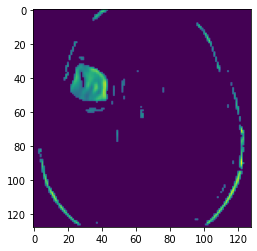

In [259]:
plt.imshow(c[0][0].detach().cpu())